In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')


In [114]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 5.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-macosx_10_12_x86_64.whl size=61728 sha256=1063a9b2c91a9a8998adfbe64f9bb1301f04d240c3e7d5920e622f3967376ecc
  Stored in directory: /Users/gianlucabontempi/Library/Caches/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [120]:
import numpy as np
from annoy import AnnoyIndex

def find_knn(data, query_point, k, metric='euclidean'):
  """Finds the K nearest neighbors of a query point in a dataset.

  Args:
    data: A NumPy array representing the dataset.
    query_point: A NumPy array representing the query point.
    k: The number of nearest neighbors to find.
    metric: The distance metric to use ('euclidean', 'angular', etc.).

  Returns:
    A tuple containing two NumPy arrays:
      - The indices of the K nearest neighbors in the dataset.
      - The distances to the K nearest neighbors.
  """

  num_dimensions = data.shape[1]
  index = AnnoyIndex(num_dimensions, metric)

  for i, point in enumerate(data):
    index.add_item(i, point)

  index.build(10)  # Build the index with 10 trees (adjust as needed)

  indices = index.get_nns_by_vector(query_point, k, include_distances=False)

  return indices

# Library of regression algorithms

In [157]:


  
def predpy(algo, X_train, y_train, X_test,params={"m":1, "nepochs":100}):
    m=1
    nepochs=100
    yhat=0
    
    if "m" in params:
        m=params["m"]

    if "nepochs" in params:
        nepochs=params["nepochs"]

    Nts=X_test.shape[0]
    n=X_train.shape[1]
    if algo=="lazy_regr0":

        k = 5  # Find the 5 nearest neighbors
        yhat=np.zeros(Nts)
        for i in np.arange(Nts):
            indices = find_knn(X_train, X_test[i,:], k)
            yhat[i]=np.mean(y_train[indices])
            
    if algo=="lazy_regr":
        from sklearn.linear_model import LassoCV
        k = 3*n  
        yhat=np.zeros(Nts)
        selected_features = mrmr_regression(pd.DataFrame(X_train), y_train, K=5)
        X_train=X_train[:,selected_features]
        X_test=X_test[:,selected_features]
        for i in np.arange(Nts):
            indices = find_knn(X_train, X_test[i,:], k)
            Xl=X_train[indices,:]
            Yl=y_train[indices]
            reg = LassoCV(cv=2, random_state=0).fit(Xl, Yl)
        
            yhat[i] = reg.predict(X_test[i,:].reshape(1,-1))
            
    
    if algo=="keras0_regr":
        from tensorflow import keras 
        from tensorflow.keras import layers
        def build_model():
          model = keras.Sequential([              
              layers.Dense(4, activation="relu"),
              layers.Dropout(0.95),
              layers.Dense(2, activation="relu"),
              layers.Dense(m)
          ])
          model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
          return model
        model = build_model()                                
        model.fit(X_train, y_train,                 
                epochs=nepochs, batch_size=10, verbose=0, validation_split=0.2)

        yhat=model.predict(X_test)
    
    if algo=="keras_regr":
    # Based on Keras Tuner
    ## https://keras.io/keras_tuner/
    ##  https://www.tensorflow.org/tutorials/keras/keras_tuner
        from tensorflow import keras 
        from tensorflow.keras import layers
        import keras_tuner as kt
        import tensorflow as tf
        def model_builder(hp):
              model = keras.Sequential()
              # Tune the number of units in the first Dense layer
              # Choose an optimal value between 32-512
              hp_units = hp.Int('units', min_value=1, max_value=20, step=1)
              model.add(keras.layers.Dense(units=hp_units, activation='relu'))
              hp_units2 = hp.Int('units2', min_value=2, max_value=10, step=2)
              model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
              hp_droprate = hp.Choice('droprate', values=[0.1, 0.5, 0.7, 0.9])
              model.add(keras.layers.Dropout(hp_droprate))
              model.add(keras.layers.Dense(m))

              model.compile(optimizer="rmsprop",
                          loss="mse",
                          metrics=['accuracy'])

              return model

        tuner = kt.Hyperband(model_builder,
                           objective='val_accuracy',
                           max_epochs=10,
                           factor=3)

        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        tuner.search(X_train, y_train,
          epochs=50, validation_split=0.2, callbacks=[stop_early],verbose=0)

        # Get the optimal hyperparameters
        best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)
        history =model.fit(X_train, y_train,epochs=nepochs, batch_size=10, 
          validation_split=0.25, verbose=0)

        #val_acc_per_epoch = history.history['val_accuracy']
        #best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1                              
        #hypermodel = tuner.hypermodel.build(best_hps)
        # Retrain the model
        #hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2,verbose=0)
        yhat=model.predict(X_test)
    
    
    if algo=="pls_regr":
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import RandomizedSearchCV
        random_grid = {'n_components': [int(x) for x in np.linspace(1, 20, num = 15)]}
        reg = PLSRegression()

        pls_regressor = RandomizedSearchCV(estimator = reg, param_distributions = random_grid,
        n_iter = 70, cv = 3, verbose=0, random_state=42)

        pls_regressor.fit(X_train, y_train)
        yhat = pls_regressor.predict(X_test)
    
    if algo=="ridge_regr":
        from sklearn.linear_model import RidgeCV

        reg = RidgeCV(alphas=np.linspace(0.1, 100, num = 50))
        reg.fit(X_train, y_train)
        yhat = reg.predict(X_test)

    
    if algo=="lasso_regr":  
        from sklearn.linear_model import LassoCV, MultiTaskLassoCV
        if m==1:
          reg = LassoCV(cv=10, random_state=0).fit(X_train, y_train)
        else:
          reg = MultiTaskLassoCV(cv=2, random_state=0,max_iter=10,
          verbose=0).fit(X_train, y_train)
        yhat = reg.predict(X_test)
    
    if algo=="enet_regr":  
        from sklearn.linear_model import ElasticNet, MultiTaskElasticNet
        from sklearn.model_selection import RandomizedSearchCV

        if m==1:
          reg = ElasticNet(random_state=0).fit(X_train, y_train)
        else:
          random_grid = {'alpha': [int(x) for x in np.linspace(0.1, 2, num = 10)]}
          reg =MultiTaskElasticNet()
          reg = RandomizedSearchCV(estimator = reg, param_distributions = random_grid,
          n_iter = 50, cv = 3, verbose=0, random_state=42)
          reg.fit(X_train, y_train)

        yhat = reg.predict(X_test)
    
    
    
    if algo=="lin_regr":
        # Create linear regression object
        from sklearn import linear_model
        linear_regressor = linear_model.LinearRegression()
        linear_regressor.fit(X_train, y_train)
        yhat = linear_regressor.predict(X_test)
  
    if algo=="rf_regr0":
        from sklearn.ensemble import RandomForestRegressor
        #from sklearn.model_selection import GridSearchCV
        from sklearn.model_selection import RandomizedSearchCV

        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]

        # Create the random grid
        random_grid = {'max_depth': max_depth}
        #             'min_samples_split': min_samples_split,
        #               'min_samples_leaf': min_samples_leaf}
        rf_r = RandomForestRegressor()
        rf_regressor = RandomizedSearchCV(estimator = rf_r, param_distributions = random_grid,
          n_iter = 5, cv = 3, verbose=0, random_state=42)
        rf_regressor =rf_r
        rf_regressor.fit(X_train, y_train)
        yhat = rf_regressor.predict(X_test)
  
    if algo=="rf_regr":
        from sklearn.ensemble import RandomForestRegressor
        #from sklearn.model_selection import GridSearchCV
        from sklearn.model_selection import RandomizedSearchCV
        rf_r = RandomForestRegressor()
        #if m>1:
        #  from sklearn.multioutput import RegressorChain
        #  rf_r = RegressorChain(base_estimator=rf_r, order='random')
        rf_regressor =rf_r

        rf_regressor.fit(X_train, y_train)

        yhat = rf_regressor.predict(X_test)
    
   
    if algo=="knn_regr":
        from sklearn.neighbors import KNeighborsRegressor
        from sklearn.model_selection import RandomizedSearchCV

        # Create the random grid
        random_grid = {'n_neighbors': [int(x) for x in np.linspace(3, 20, num = 10)],
                  'weights':['uniform', 'distance']}
        knn_r = KNeighborsRegressor()

        knn_regressor = RandomizedSearchCV(estimator = knn_r, param_distributions = random_grid,
        n_iter = 50, cv = 3, verbose=0, random_state=42)
        knn_regressor.fit(X_train, y_train)
        yhat = knn_regressor.predict(X_test)
    
    if algo=="gb_regr":
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.model_selection import RandomizedSearchCV
        if m>1:
          #from sklearn.multioutput import MultiOutputRegressor
          #gb_regressor = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5))
          from sklearn.multioutput import RegressorChain
          gb_regressor = RegressorChain(base_estimator=GradientBoostingRegressor(), order='random')
          random_grid = {'base_estimator__n_estimators': [int(x) for x in np.linspace(1, 20, num = 5)]}
        else:
          gb_regressor = GradientBoostingRegressor()
          random_grid = {'n_estimators': [int(x) for x in np.linspace(1, 20, num = 5)]}

        gb_regressor = RandomizedSearchCV(estimator = gb_regressor, param_distributions = random_grid,
        n_iter = 20, cv = 2, verbose=0, random_state=42)

        gb_regressor.fit(X_train, y_train)

        yhat = gb_regressor.predict(X_test)
   
    
    if algo=="ab_regr":
        from sklearn.ensemble import AdaBoostRegressor
        from sklearn.tree import DecisionTreeRegressor
        if m>1:
          from sklearn.multioutput import MultiOutputRegressor
          ab_regressor = MultiOutputRegressor(AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), 
            n_estimators=400, random_state=7))
          random_grid = {'estimator__base_estimator__max_depth': [int(x) for x in np.linspace(1, 10, num = 5)]}
        else:
          ab_regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=400, random_state=7)
          random_grid = {'base_estimator__max_depth': [int(x) for x in np.linspace(1, 10, num = 5)]}

        ab_regressor = RandomizedSearchCV(estimator = ab_regressor, param_distributions = random_grid,
        n_iter = 20, cv = 2, verbose=0, random_state=42)

        ab_regressor.fit(X_train, y_train)
        yhat = ab_regressor.predict(X_test)
    
  
  
    
    if algo=="piperf_regr":  
        from sklearn.pipeline import Pipeline
        from sklearn.feature_selection import SelectFromModel
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.multioutput import RegressorChain
        #if m>1:
        #  clf = Pipeline([
        #  ('feature_selection', SelectFromModel(RandomForestRegressor())),
        #  ('regression', RegressorChain(base_estimator=RandomForestRegressor(), order='random'))
        #  ])
        #else:
        clf = Pipeline([
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', RandomForestRegressor())
          ])
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)
    
    if algo=="pipeknn_regr":  
        from sklearn.pipeline import Pipeline
        from sklearn.feature_selection import SelectFromModel
        from sklearn.neighbors import KNeighborsRegressor
        from sklearn.ensemble import RandomForestRegressor
        from sklearn.model_selection import RandomizedSearchCV
        knn_r = Pipeline([
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', KNeighborsRegressor())
        ])
        random_grid = {'feature_selection__max_features': [int(x) for x in np.linspace(1, 10, num = 5)],
        'regression__n_neighbors': [int(x) for x in np.linspace(1, 20, num = 5)]}
        knn_regressor = RandomizedSearchCV(estimator = knn_r, param_distributions = random_grid,
        n_iter = 20, cv = 2, verbose=0, random_state=42)
        knn_regressor.fit(X_train, y_train)
        yhat = knn_regressor.predict(X_test)
    
    if algo=="pipelin_regr":  
        clf = Pipeline([
          ('reduce_dim', PCA()),
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', linear_model.LinearRegression())
        ])
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)

    
    if algo=="pipeab_regr":  
        clf = Pipeline([
          ('feature_selection', SelectFromModel(RandomForestRegressor())),
          ('regression', AdaBoostRegressor(n_estimators=500))
        ])
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)

        yhat.shape=(int(Nts),int(m))
    
    
    if algo=="torch_regr":

        # Convert to PyTorch tensors
        X_trainT = torch.tensor(X_train, dtype=torch.float32)
        y_trainT = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Unsqueeze for shape
        X_testT = torch.tensor(X_test, dtype=torch.float32)

        train_dataset = TensorDataset(X_trainT, y_trainT)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_dataset = TensorDataset(X_testT)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 2. Define the Neural Network Model:
        class RegressionModel(nn.Module):
            def __init__(self, input_size, hidden_size, output_size):
                super(RegressionModel, self).__init__()
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.relu = nn.ReLU()
                self.fc1a = nn.Linear(hidden_size, hidden_size)
                self.fc2 = nn.Linear(hidden_size, output_size)

            def forward(self, x):
              out = self.fc1(x)
              out = self.relu(out)
              #out = self.fc1a(out)
              #out = self.relu(out)
              out = self.fc2(out)
              return out

        # Instantiate the model
        input_size = X_trainT.shape[1]  # Number of features
        hidden_size = 12  # Adjust as needed
        output_size = m   # For regression
        model = RegressionModel(input_size, hidden_size, output_size)


        optimizer = optim.Adam(model.parameters())
        criterion = nn.MSELoss()  # Mean Squared Error for regression

      # Training loop
        epochs = nepochs  # Adjust as needed
    
        for epoch in range(epochs):
          for batch_idx, (data, target) in enumerate(train_loader):
              optimizer.zero_grad()
              output = model(data)
              loss = criterion(output, target)
              loss.backward()
              optimizer.step()
          #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

        model.eval()  # Set the model to evaluation mode
        yhat=[]
        #import pdb
        with torch.no_grad():  # Don't calculate gradients during evaluation
          total_loss = 0
          for data in test_loader:
              #pdb.set_trace()  
              output = model(data[0])
              yhat=np.append(yhat,output.numpy())
          


    if type(yhat)==int:
        print(algo)
        raise ValueError("Method not present")
    return yhat  


# Regression

In [158]:

## dataset creation

N = 200
n = 10
X = np.random.normal(size=(N, n))
Y = X[:, 0] * X[:, 1]**2 + np.log(abs(X[:, 3]))+ np.random.normal(scale=0.1, size=N)

Yhat = np.zeros(N)
Yhat2 = np.zeros(N)
Yhat3 = np.zeros(N)


## number folds
K = 2
kf = KFold(n_splits=K, shuffle=False)


for train_index, test_index in kf.split(X):
    Xtrk=X[train_index,:]
    Ytrk=Y[train_index].reshape(len(train_index),)
    Yhat[test_index] = predpy("lazy_regr",Xtrk ,Ytrk , X[test_index],params={'nepochs':100})
    Yhat2[test_index] = predpy("gb_regr",Xtrk ,Ytrk , X[test_index])
    Yhat3[test_index] = predpy("pipeknn_regr",Xtrk ,Ytrk , X[test_index])



print(f'Lazy MSE: {np.mean((Yhat - Y)**2) / np.var(Y):.4f}; RF MSE: {np.mean((Yhat2 - Y)**2) / np.var(Y):.4f}; KNN MSE: {np.mean((Yhat3 - Y)**2) / np.var(Y):.4f}')


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.35it/s]


Lazy MSE: 0.7877; RF MSE: 0.6444; KNN MSE: 0.5357


# Feature selection

In [144]:
!pip install mrmr_selection

In [150]:
from  mrmr import mrmr_regression

In [168]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

N = 200
n = 10
X = np.random.normal(size=(N, n))
Y = X[:, 0] * X[:, 1]**2 + np.log(abs(X[:, 3]))+ np.random.normal(scale=0.1, size=N)
#selected_features = mrmr_regression(pd.DataFrame(X), Y, K=3)
#selected_features

X=pd.DataFrame(X)
lasso = Lasso(alpha=0.05)  # Adjust alpha (regularization strength) as needed
lasso.fit(X, Y)

# 4. Get selected features
selected_features = X.columns[lasso.coef_ != 0]

selected_features

Index([0, 1, 2, 5, 7, 8, 9], dtype='int64')

In [165]:
lasso.coef_

array([ 0.87339787,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.05515889,  0.        ,  0.        ])

# Forecasting

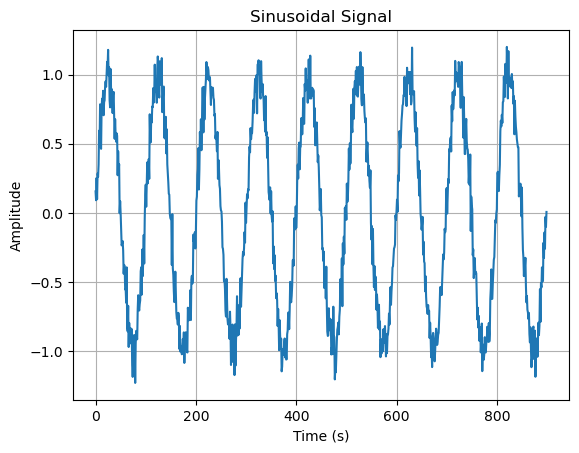

Torch MSE: 0.0284; RF MSE: 0.0694; KNN MSE: 0.0369


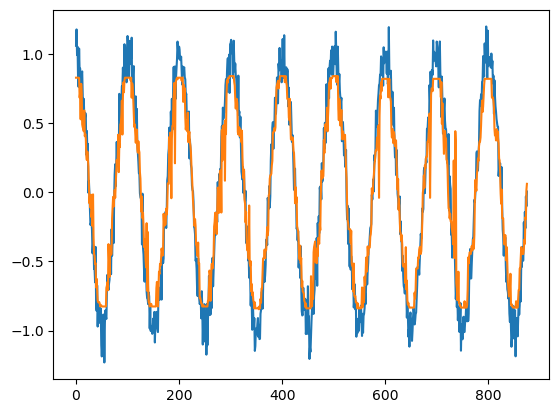

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Sample time series data
# Parameters for the sinusoidal signal
frequency = 0.3  # Frequency in Hz
amplitude = 1  # Amplitude
phase = 0  # Phase shift in radians
duration = 30  # Duration in seconds
sampling_rate = 30  # Number of samples per second

# Time vector
time = np.linspace(0, duration, int(duration * sampling_rate))

# Generate the sinusoidal signal
tseries = amplitude * np.sin(2 * np.pi * frequency * time + phase)+np.random.normal(scale=0.1, size=len(time))

# Print the signal values
plt.plot(tseries)
plt.title('Sinusoidal Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


lag=15
H=10
# Create windows of size 3 with a step of 1
Embed = np.lib.stride_tricks.sliding_window_view(tseries, window_shape=lag+H)

X=Embed[:,:lag]
Y=Embed[:,-1]

N=X.shape[0]
Yhat = np.zeros(N)
Yhat2 = np.zeros(N)
Yhat3 = np.zeros(N)


## number folds
K = 3
kf = KFold(n_splits=K, shuffle=False)


for train_index, test_index in kf.split(X):
    Xtrk=X[train_index,:]
    Ytrk=Y[train_index].reshape(len(train_index),)
    Yhat[test_index] = predpy("lazy_regr",Xtrk ,Ytrk , X[test_index],params={'nepochs':100})
    Yhat2[test_index] = predpy("gb_regr",Xtrk ,Ytrk , X[test_index])
    Yhat3[test_index] = predpy("pipeknn_regr",Xtrk ,Ytrk , X[test_index])

Yhat=Yhat.reshape(Y.shape)
Yhat2=Yhat2.reshape(Y.shape)
Yhat3=Yhat3.reshape(Y.shape)

print(f'LAzy MSE: {np.mean((Yhat - Y)**2) / np.var(Y):.4f}; RF MSE: {np.mean((Yhat2 - Y)**2) / np.var(Y):.4f}; KNN MSE: {np.mean((Yhat3 - Y)**2) / np.var(Y):.4f}')
plt.plot(Y)
plt.plot(Yhat2)

plt.show()


# Time series preprocessing

https://gist.github.com/banditkings/26f640c2e56d91f24c2d4c65087bab5a

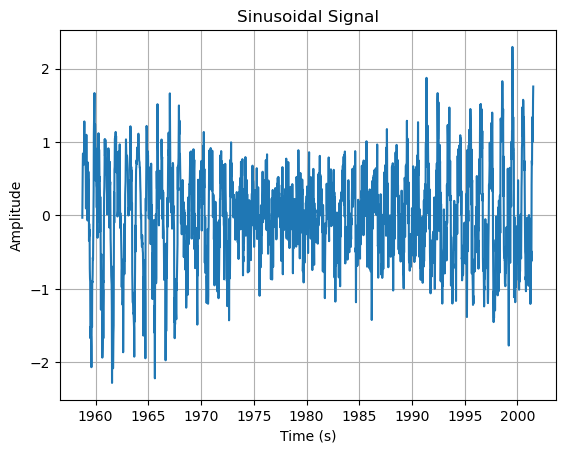

In [135]:
import pandas as pd
from statsmodels.datasets import get_rdataset

# Load the Air Passengers dataset
air_passengers = get_rdataset("AirPassengers").data
tseries = air_passengers.value


##
import statsmodels.api as sm
df = sm.datasets.nile.load().data
df['ds'] = pd.date_range(start='1871', end='1970', freq='AS')
tseries=df['volume']

import statsmodels.api as sm
df = sm.datasets.co2.load_pandas().data
tseries=df['co2']

tseries= tseries.interpolate(method='linear')

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(tseries, model='additive')

# Extract the detrended component (residuals)
tseries = result.resid.dropna()




#tseries=tseries.diff().dropna()

# Print the signal values
plt.plot(tseries)
plt.title('Sinusoidal Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()



# Time series (direct) forecasting

Lazy MSE: 0.4150; RF MSE: 0.4259; KNN MSE: 0.4121


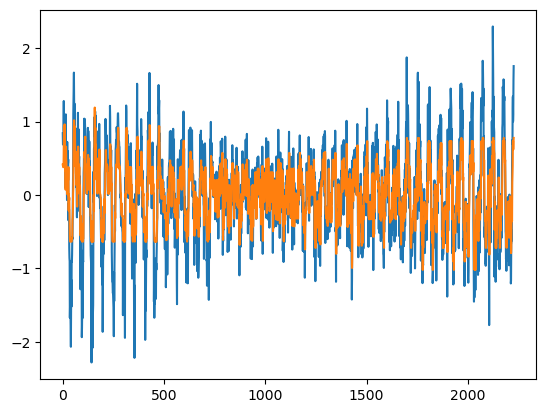

In [136]:

lag=5
H=1
# Create windows of size 3 with a step of 1
Embed = np.lib.stride_tricks.sliding_window_view(tseries, window_shape=lag+H)

X=Embed[:,:lag]
Y=Embed[:,-1]

N=X.shape[0]
Yhat = np.zeros(N)
Yhat2 = np.zeros(N)
Yhat3 = np.zeros(N)


## number folds
K = 3
kf = KFold(n_splits=K, shuffle=False)


for train_index, test_index in kf.split(X):
    Xtrk=X[train_index,:]
    Ytrk=Y[train_index].reshape(len(train_index),)
    Yhat[test_index] = predpy("lazy_regr",Xtrk ,Ytrk , X[test_index],params={'nepochs':100})
    Yhat2[test_index] = predpy("gb_regr",Xtrk ,Ytrk , X[test_index])
    Yhat3[test_index] = predpy("pipeknn_regr",Xtrk ,Ytrk , X[test_index])

Yhat=Yhat.reshape(Y.shape)
Yhat2=Yhat2.reshape(Y.shape)
Yhat3=Yhat3.reshape(Y.shape)

print(f'Lazy MSE: {np.mean((Yhat - Y)**2) / np.var(Y):.4f}; RF MSE: {np.mean((Yhat2 - Y)**2) / np.var(Y):.4f}; KNN MSE: {np.mean((Yhat3 - Y)**2) / np.var(Y):.4f}')
plt.plot(Y)
plt.plot(Yhat2)

plt.show()